# CISA KVE EPSS Data Analyis 

In [1]:
import pandas as pd
import json
import requests
import os
import glob
import numpy as np

In [2]:
cisa_df = pd.read_csv("https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv")
cisa_df = cisa_df
cisa_df.columns = cisa_df.columns.str.strip("\u200b")
cisa_df = cisa_df.rename(columns={"cveID": "CVE", "shortDescription" : "Description", "vendorProject" : "Vendor", "product" : "Product"})

In [3]:
epss = pd.read_csv('epss_scores-current.csv', skiprows=1)
epss = epss.rename(columns={"cve": "CVE", "epss" : "EPSS", "percentile" : "EPSS Percentile"})

In [4]:
row_accumulator = []
for filename in glob.glob('nvdcve-2.0-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['vulnerabilities']:
            cve = entry['cve']['id']
            base_score = 0.0
            metrics = entry['cve'].get('metrics', {})
            cvss_v31 = metrics.get('cvssMetricV31', [{}])
            if cvss_v31 and 'cvssData' in cvss_v31[0]:
                base_score = cvss_v31[0]['cvssData'].get('baseScore', 0.0)
            new_row = {
                'CVE': cve,
                'CVSS3': base_score,
            }
            row_accumulator.append(new_row)

# Create DataFrame after all files are processed
nvd = pd.DataFrame(row_accumulator)
nvd['CVSS3'] = pd.to_numeric(nvd['CVSS3'])
nvd['CVSS3'] = nvd['CVSS3'].replace(0, np.nan)

In [5]:
epss_kev = pd.merge(cisa_df, epss, left_on='CVE', right_on='CVE')
epss_kev_nvd =  pd.merge(epss_kev, nvd, left_on='CVE', right_on='CVE')
epss_kev_nvd =  epss_kev_nvd[["CVE", "CVSS3", "EPSS", "EPSS Percentile", "Description", "Vendor", "Product"]]

In [6]:
epss_kev_nvd

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Vendor,Product
0,CVE-2025-47827,8.4,0.00006,0.00244,IGEL OS contains a use of a key past its expir...,IGEL,IGEL OS
1,CVE-2025-6264,5.5,0.00047,0.14127,Rapid7 Velociraptor contains an incorrect defa...,Rapid7,Velociraptor
2,CVE-2016-7836,NaN,0.37702,0.96995,SKYSEA Client View contains an improper authen...,SKYSEA,Client View
3,CVE-2021-43798,7.5,0.94438,0.99987,Grafana contains a path traversal vulnerabilit...,Grafana Labs,Grafana
4,CVE-2025-27915,5.4,0.25535,0.95948,Synacor Zimbra Collaboration Suite (ZCS) conta...,Synacor,Zimbra Collaboration Suite (ZCS)
...,...,...,...,...,...,...,...
1434,CVE-2021-27561,9.8,0.94106,0.99902,Yealink Device Management contains a server-si...,Yealink,Device Management
1435,CVE-2021-40539,9.8,0.94424,0.99979,Zoho ManageEngine ADSelfService Plus contains ...,Zoho,ManageEngine
1436,CVE-2020-10189,9.8,0.94248,0.99924,Zoho ManageEngine Desktop Central contains a f...,Zoho,ManageEngine
1437,CVE-2019-8394,6.5,0.87312,0.99410,Zoho ManageEngine ServiceDesk Plus (SDP) conta...,Zoho,ManageEngine


## CISA KEV Score Scatter Plot

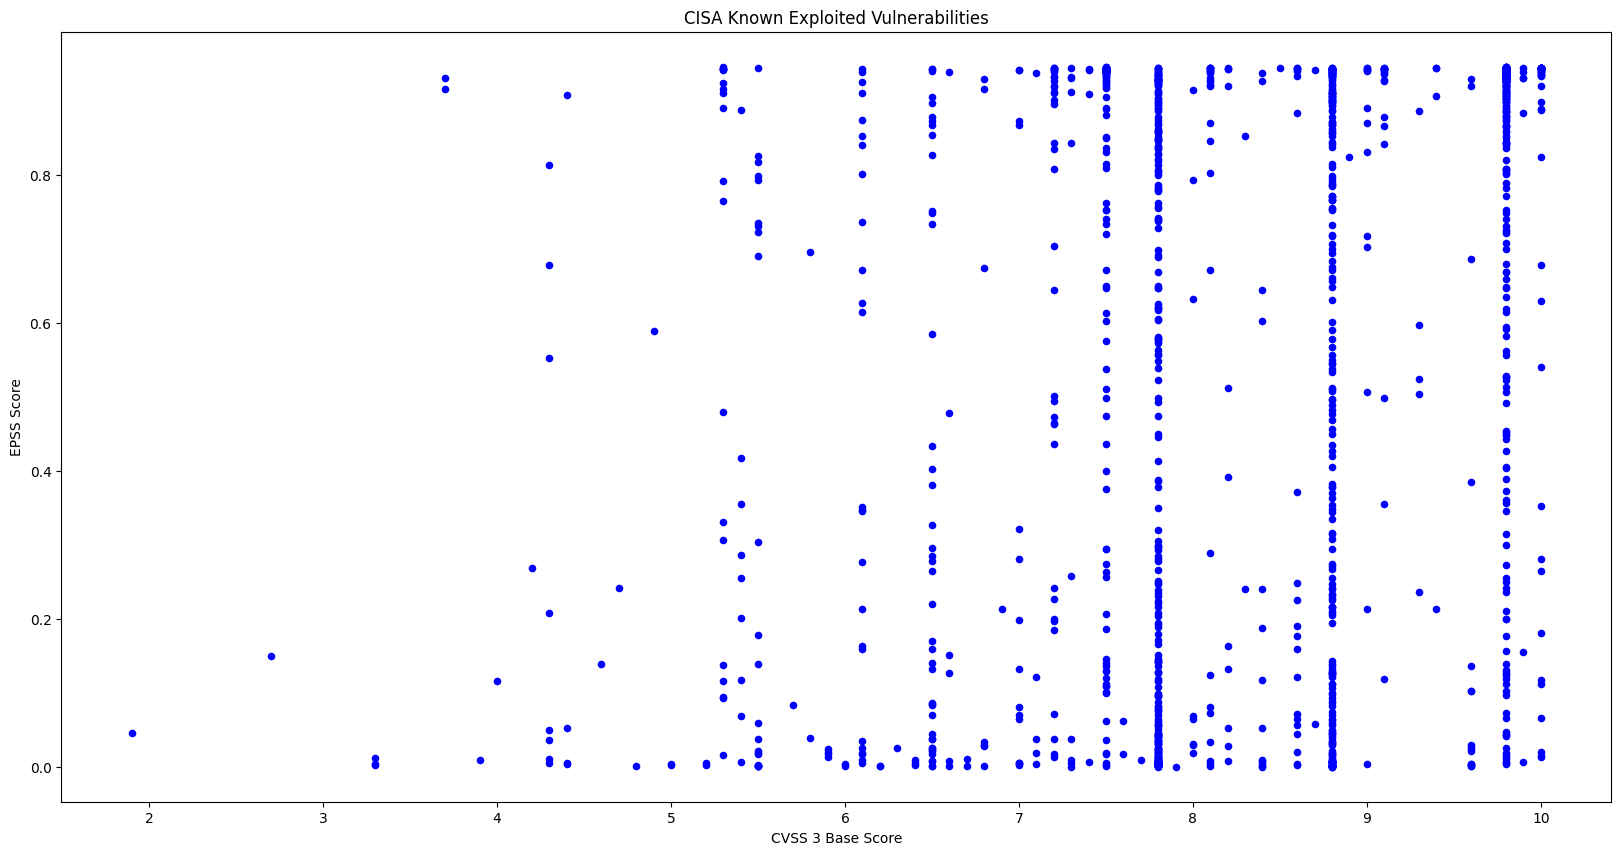

In [7]:
ax = epss_kev_nvd.plot.scatter(x='CVSS3',
                                 y='EPSS',
                                 figsize=(20, 10),
                                 title='CISA Known Exploited Vulnerabilities',
                                 color='blue')
ax.set_xlabel("CVSS 3 Base Score")
ax.set_ylabel("EPSS Score")
ax.get_figure().savefig('epss_kev_nvd.png')

## Export to CVS

In [8]:
epss_kev_nvd.to_csv("epss_kev_nvd.csv", index=False)
epss_kev_nvd.head(10)

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Vendor,Product
0,CVE-2025-47827,8.4,0.00006,0.00244,IGEL OS contains a use of a key past its expir...,IGEL,IGEL OS
1,CVE-2025-6264,5.5,0.00047,0.14127,Rapid7 Velociraptor contains an incorrect defa...,Rapid7,Velociraptor
2,CVE-2016-7836,NaN,0.37702,0.96995,SKYSEA Client View contains an improper authen...,SKYSEA,Client View
3,CVE-2021-43798,7.5,0.94438,0.99987,Grafana contains a path traversal vulnerabilit...,Grafana Labs,Grafana
4,CVE-2025-27915,5.4,0.25535,0.95948,Synacor Zimbra Collaboration Suite (ZCS) conta...,Synacor,Zimbra Collaboration Suite (ZCS)
5,CVE-2021-22555,8.3,0.85232,0.99314,Linux Kernel contains a heap out-of-bounds wri...,Linux,Kernel
6,CVE-2010-3962,8.1,0.86935,0.99392,Microsoft Internet Explorer contains an uninit...,Microsoft,Internet Explorer
7,CVE-2021-43226,7.8,0.38585,0.97054,Microsoft Windows Common Log File System Drive...,Microsoft,Windows
8,CVE-2013-3918,8.8,0.87059,0.99399,Microsoft Windows contains an out-of-bounds wr...,Microsoft,Windows
9,CVE-2011-3402,8.8,0.89746,0.99536,Microsoft Windows Kernel contains an unspecifi...,Microsoft,Windows
